In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression

In [2]:
from urllib.request import urlopen
import plotly.express as px
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)



## Load and prep data tables

In [3]:
covid_df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', dtype={"fips": str}, parse_dates=['date'])

In [4]:
# Create a dataframe for counties which will be used later.
counties_df = covid_df.groupby(['fips', 'county', 'state']).agg(FIPS = ('fips', 'max'),
                                                              COUNTY = ('county', 'max'),
                                                              ST = ('state', 'max')
                                                             ).reset_index()[['FIPS', 'COUNTY', 'ST']]

In [5]:
# NYT covid cases are cumulative. Calculate incremental new cases for each county (fips).
covid_df['cases_new'] = covid_df.groupby('fips')['cases'].diff().fillna(0)

In [9]:
# Calculate the smoothed moving average (SMA) for each county (fips).
county_SMA = []
for fips_ in covid_df['fips'].unique():
    county_df = covid_df[covid_df['fips']==fips_]
    county_SMA.append(county_df['cases_new'].rolling(window=7).mean())
covid_df['case_SMA'] = pd.concat(county_SMA)

# Calculate the datapoints that are used in the NYT charts--SMA peak prior to Oct 1 and current average (I am using ave of SMA).
county_prev_peak, county_curr_ave = [], []
for fips_ in counties_df['FIPS'].unique():
    county_prev_peak.append(covid_df[(covid_df['fips']==fips_) & (covid_df['date'] < '2020-10-01')]['case_SMA'].max())
    county_curr_ave.append(covid_df[(covid_df['fips']==fips_) & (covid_df['date'] > '2020-10-01')]['case_SMA'][-7:].mean())

In [37]:
counties_df['curr_ave'] = county_curr_ave
counties_df['prev_peak'] = county_prev_peak
counties_df['Current to Peak Ratio'] = counties_df['curr_ave'] / counties_df['prev_peak'] 

In [43]:
fig = px.choropleth_mapbox(counties_df, geojson=counties, locations='FIPS', color='Current to Peak Ratio',
                           color_continuous_scale="Viridis",
                           range_color=(0, 3),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'COVID_Incidence_Rate':'COVID Incidence Rate 7/31/2020'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("img/curr_vs_peak_covid.png")
fig.write_html('img/curr_vs_peak_covid.html', auto_open=True)


In [45]:
# Let's adjust the case numbers to correct for undercount rate and rerun the data and charts.
covid_df['cases_new_adj'] = np.where(covid_df['date']<'2020-06-01', covid_df['cases_new']*6, 
                                     covid_df['cases_new']*2.1)


In [46]:
# Calculate the smoothed moving average (SMA) for each county (fips).
county_SMA = []
for fips_ in covid_df['fips'].unique():
    county_df = covid_df[covid_df['fips']==fips_]
    county_SMA.append(county_df['cases_new_adj'].rolling(window=7).mean())
covid_df['case_adj_SMA'] = pd.concat(county_SMA)

# Calculate the datapoints that are used in the NYT charts--SMA peak prior to Oct 1 and current average (I am using ave of SMA).
county_prev_peak_adj, county_curr_ave_adj = [], []
for fips_ in counties_df['FIPS'].unique():
    county_prev_peak_adj.append(covid_df[(covid_df['fips']==fips_) & (covid_df['date'] < '2020-10-01')]['case_adj_SMA'].max())
    county_curr_ave_adj.append(covid_df[(covid_df['fips']==fips_) & (covid_df['date'] > '2020-10-01')]['case_adj_SMA'][-7:].mean())

In [47]:
counties_df['curr_ave_adj'] = county_curr_ave_adj
counties_df['prev_peak_adj'] = county_prev_peak_adj
counties_df['Adjusted Current to Peak Ratio'] = counties_df['curr_ave_adj'] / counties_df['prev_peak_adj'] 

In [50]:
fig = px.choropleth_mapbox(counties_df, geojson=counties, locations='FIPS', color='Adjusted Current to Peak Ratio',
                           color_continuous_scale="Viridis",
                           range_color=(0, 3),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'COVID_Incidence_Rate':'COVID Incidence Rate 7/31/2020'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("img/adj_curr_vs_peak_covid.png")
fig.write_html('img/adj_curr_vs_peak_covid.html', auto_open=True)


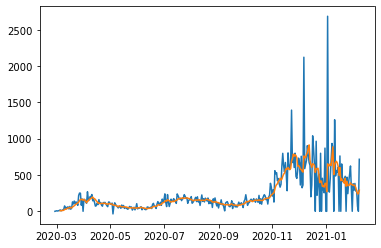

In [51]:
fig,ax = plt.subplots()
ax.plot(covid_df[covid_df['fips']=='53033']['date'],covid_df[covid_df['fips']=='53033']['cases_new'])
ax.plot(covid_df[covid_df['fips']=='53033']['date'],covid_df[covid_df['fips']=='53033']['case_SMA'])


In [49]:
counties_df.to_csv('../data/covid_curr_to_peak_comparison_3x.csv')